# Data coverage & quality

In this notebook we will go through the data tables that are used in analytics and modeling and check the coverage and quality of the data.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from box import Box
from google.cloud import bigquery

In [32]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
client = bigquery.Client(project=config.GCP.PROJECT_ID)
# Set the BigQuery dataset schema
read_schema = config.GCP.READ_SCHEMA
ingestion_schema = config.GCP.INGESTION_SCHEMA
analytics_schema = config.GCP.ANALYTICS_SCHEMA

# Define the color palette
palette = {'good': config.DASHBOARD.COLORS.GOOD_COLOR,
           'warning': config.DASHBOARD.COLORS.WARNING_COLOR,
           'bad': config.DASHBOARD.COLORS.BAD_COLOR}
DEFAULT_VALUE = 'n/a'

In [33]:
def column_coverage(series: pd.Series, default_value: object) -> float:
    """
    Calculate the coverage of a column in percentage.
    :param series: Pandas Series
    :param default_value: Default value to be considered as missing
    :return: Coverage of the column in percentage
    """
    # Calculate the coverage of the column in percentage by dividing the number 
    # of non-default values to the total number of values

    # If type of series is boolean then default value is False
    if series.dtype == 'boolean':
        # If the series is of boolean type, count the True values
        coverage = series.sum() / series.shape[0] * 100
    else:
        coverage = series[series != default_value].shape[0] / series.shape[0] * 100
    return coverage


def table_health(df: pd.DataFrame, default_value: str) -> pd.DataFrame:
    """
    Calculate the health metrics of a DataFrame.
    :param df: Pandas DataFrame
    :param default_value: Default value to be considered as missing
    :return: Health metrics of the DataFrame
    """
    # list to store the health metrics of the DataFrame
    list_table__health = []
    # Iterate over the columns of the DataFrame
    for column in df.columns:
        # Calculate the coverage of the column
        coverage = column_coverage(series=df[column], default_value=default_value)

        # Append the health metrics to the DataFrame
        list_table__health.append(
            dict(column_name=column,
                 coverage=coverage)
        )

    # Return the health metrics as a DataFrame sorted by coverage
    return pd.DataFrame(list_table__health).sort_values(by='coverage', ascending=False)


# Define the color mapping based on coverage
def get_color_label(coverage):
    """
    Get the color label based on the coverage percentage.
    :param coverage: Coverage percentage
    :return: Color label
    """
    if coverage > 90:
        return 'good'
    elif coverage > 70:
        return 'warning'
    else:
        return 'bad'


def plot_health_metrics(df_source: pd.DataFrame, table_name: str, default_value: str, palette: dict):
    """
    Plot the health metrics of a DataFrame.
    :param df_source: Pandas DataFrame to be analyzed
    :param table_name: Name of the table
    :param default_value: Default value to be considered as missing
    :param palette: Color palette 
    """
    # Calculate the health metrics of the table
    df_health = table_health(df=df_source,
                             default_value=default_value)

    # Visualize the health metrics using a bar chart with the coverage on the y-axis.
    # We use 'good' color for coverage above 90%, 'warning' color for coverage between 70% and 90%
    # and 'bad' color for coverage below 70%.

    # Apply the function to create a new column for color labels
    df_health['color_label'] = df_health['coverage'].apply(get_color_label)

    # Create the bar plot with data labels with hue based on the color labels
    ax = sns.barplot(x='coverage', y='column_name', data=df_health,
                     hue='color_label', palette=palette, dodge=False, legend=False)
    # Add the data labels to the plot (truncated to 0 decimal points)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge')
    plt.xlabel('Coverage (%)')
    plt.ylabel('Column')
    # Set the title of the plot
    plt.title(f'{table_name} - Health Metrics')
    plt.xlim(0, 100)
    plt.show()


## DIM_ARTICLE

Read the `DIM_ARTICLE` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [34]:
query_article = f"""
SELECT
    *
FROM
    {read_schema}.DIM_ARTICLE
"""

df_article = client.query(query_article).to_dataframe()
df_article.head(10)

,ARTICLE_SID,ARTICLE_DOI,ARTICLE_URL,ARTICLE_TITLE,ARTICLE_LANGUAGE,ARTICLE_PUBLICATION_DT,IS_ARTICLE_ENGLISH,IS_ARTICLE_OPEN_ACCESS,HAS_SUFFICIENT_TEXT_FOR_EMBEDDING,HAS_TEXT_EMBEDDING,HAS_ABSTRACT,HAS_REFERENCES,IS_SOLE_AUTHOR_PUBLICATION,IS_INTERNAL_COLLABORATION,IS_EXTERNAL_COLLABORATION,IS_EUTOPIAN_COLLABORATION,IS_EUTOPIAN_PUBLICATION,IS_ARTICLE_RELEVANT
0,77218696dd47478baa506b3295b410da,10.1007/978-94-015-0817-9_4,http://dx.doi.org/10.1007/978-94-015-0817-9_4,Nederland,nl,1951-01-01,False,False,True,False,False,True,True,False,False,False,False,False
1,ec3ee500babb04124bd0383bb255c148,10.1007/978-3-030-84848-4_1,http://dx.doi.org/10.1007/978-3-030-84848-4_1,Cultural Consumers Becoming Reviewers,en,2022-01-01,True,False,True,True,False,True,True,False,False,False,False,False
2,b96822909bd3d11bf0fb91280ccab225,10.1017/s1049023x13000149,http://dx.doi.org/10.1017/s1049023x13000149,Hospital Ships Adrift? Part 1: A Systematic Li...,en,2013-02-15,True,False,True,True,True,True,True,False,False,False,False,False
3,0fa6cc6927098e620c6ad0d319f01803,10.1093/acprof:oso/9780199533114.003.0001,http://dx.doi.org/10.1093/acprof:oso/978019953...,Introduction,en,2009-07-30,True,False,True,True,True,True,True,False,False,False,False,False
4,959b59bdbca22bcf5bd50ec6e2ed578a,10.1090/s0002-9904-1927-04342-7,http://dx.doi.org/10.1090/s0002-9904-1927-04342-7,The Western Christmas meeting of the Society a...,en,1927-01-01,True,False,False,True,False,False,True,False,False,False,False,False
5,ffcd9e7d0e9bd528934d2f0778be0ce8,10.1007/978-1-4615-5219-2_10,http://dx.doi.org/10.1007/978-1-4615-5219-2_10,The Long Run in Macro-Economic Models: A Guide,en,1999-01-01,True,False,True,False,False,True,True,False,False,False,False,False
6,0fc1686bb5b0cf9403f117f75649f79d,10.1002/mmnd.4800390408,http://dx.doi.org/10.1002/mmnd.4800390408,Verschmelzung von Antennomeren (Symphysocerie)...,de,1992-09-04,False,False,True,False,False,True,True,False,False,False,False,False
7,4de978bb40286b1240f788bc898636f5,10.5965/cidea.v6i1.22191,http://dx.doi.org/10.5965/cidea.v6i1.22191,O teatro e a construção do humano: relato sobr...,pt,2023-03-18,False,False,True,False,True,True,True,False,False,False,False,False
8,e434f5acf0a0531f7b3f795ab14bbef7,10.52412/mf.2005.h4.642,http://dx.doi.org/10.52412/mf.2005.h4.642,"Formgenese in Wolfgang Rihms Violinkonzert ""Ge...",de,2021-09-22,False,False,True,False,True,False,True,False,False,False,False,False
9,5ed596d3750dec1bb863a980749cc268,10.1039/9781782623625-00377,http://dx.doi.org/10.1039/9781782623625-00377,Advanced Environmental Engineering Separation ...,en,2016-11-14,True,False,True,False,True,True,True,False,False,False,False,False


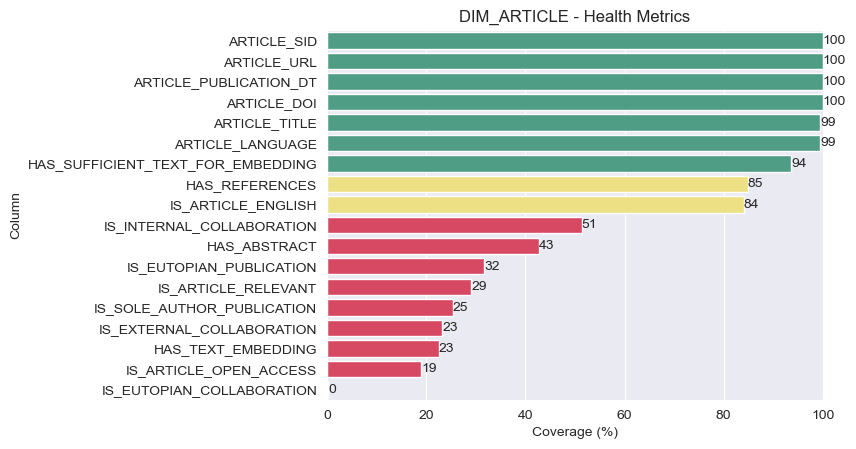

In [35]:
plot_health_metrics(df_source=df_article,
                    table_name='DIM_ARTICLE',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

### Defining articles for final analysis

After checking base data coverage, we will check how many articles were published by EUTOPIA institutions. This will serve as baseline for further data coverage analysis.
We will then check the following:
1. For how many articles we have the full text available.
2. How many articles are written in English?
3. For how many articles we already have the embeddings available.


In [36]:
query_articles_eutopia = f"""
SELECT
    COUNT(DISTINCT F.ARTICLE_SID) AS ARTICLE_COUNT
FROM
    {read_schema}.FCT_COLLABORATION F
    INNER JOIN {read_schema}.DIM_ARTICLE A USING (ARTICLE_SID)
WHERE
    F.IS_EUTOPIAN_PUBLICATION
    AND A.ARTICLE_TITLE <> 'n/a' 
"""

df_articles_eutopia = client.query(query_articles_eutopia).to_dataframe()
n_relevant_articles = df_articles_eutopia.iloc[0, 0]
print(f"Number of articles published by EUTOPIA institutions: {n_relevant_articles}")

Number of articles published by EUTOPIA institutions: 160667


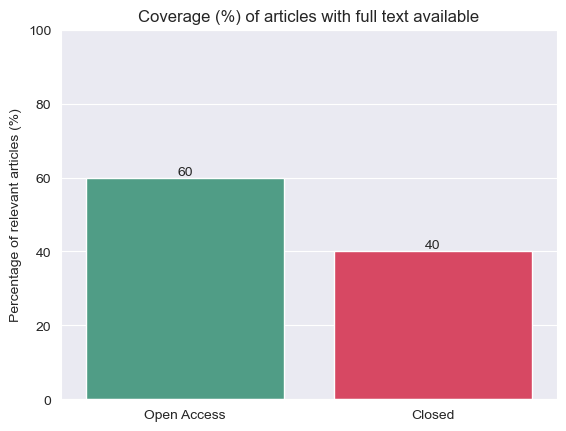

In [37]:
# Check how many articles have full text available
query_articles_full_text = f"""
SELECT
    COUNT(DISTINCT F.ARTICLE_SID) AS ARTICLE_COUNT
FROM
    {read_schema}.FCT_COLLABORATION F
    INNER JOIN {read_schema}.DIM_ARTICLE A 
        ON F.ARTICLE_SID = A.ARTICLE_SID
    INNER JOIN {read_schema}.STG_UNPAYWALL_ARTICLE OA 
        ON A.ARTICLE_DOI = OA.ARTICLE_DOI 
WHERE
    F.IS_EUTOPIAN_PUBLICATION
    AND A.ARTICLE_TITLE <> 'n/a' 
    AND OA.IS_ARTICLE_OPEN_ACCESS
"""

df_articles_full_text = client.query(query_articles_full_text).to_dataframe()
n_articles_full_text = df_articles_full_text.iloc[0, 0]

# Visualize the coverage of articles with full text available
ax = sns.barplot(x=['Open Access', 'Closed'],
                 y=[100 * n_articles_full_text / n_relevant_articles,
                    100 * (n_relevant_articles - n_articles_full_text) / n_relevant_articles],
                 hue=['Open Access', 'Closed'],
                 palette=[palette['good'], palette['bad']])

# Add the data labels to the plot (truncated to 0 decimal points)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge')
plt.ylabel('Percentage of relevant articles (%)')
plt.title('Coverage (%) of articles with full text available')
plt.ylim(0, 100)
plt.show()

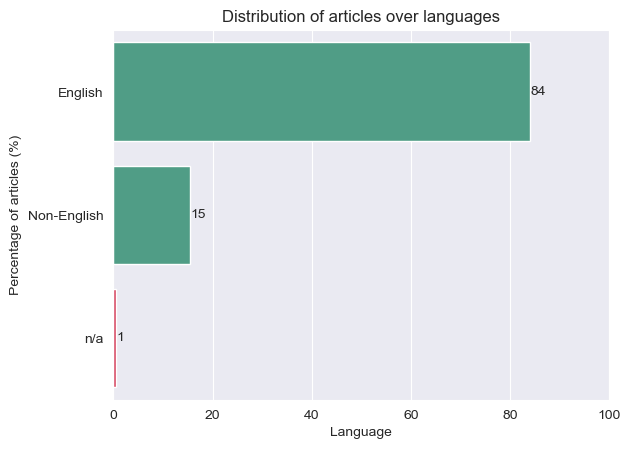

In [38]:
# Show article distribution (in %) over languages (df_article.ARTICLE_LANGUAGE) and show 'n/a' with bad color

# Split to 3 groups: English, Non-English and 'n/a'
df_article['ARTICLE_LANGUAGE_GROUP'] = df_article['ARTICLE_LANGUAGE'].apply(
    lambda x: 'English' if x == 'en' else 'Non-English' if x != DEFAULT_VALUE else DEFAULT_VALUE)

# Plot the distribution of articles over languages
ax = sns.barplot(y=df_article['ARTICLE_LANGUAGE_GROUP'].value_counts(normalize=True).index,
                 x=100 * df_article['ARTICLE_LANGUAGE_GROUP'].value_counts(normalize=True).values,
                 hue=df_article['ARTICLE_LANGUAGE_GROUP'].value_counts(normalize=True).index,
                 palette=[palette['good'] if x != DEFAULT_VALUE else palette['bad']
                          for x in df_article['ARTICLE_LANGUAGE_GROUP'].value_counts(normalize=True).index])
plt.xlabel('Language')
plt.ylabel('Percentage of articles (%)')
plt.title('Distribution of articles over languages')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge')
plt.xlim(0, 100)
plt.show()

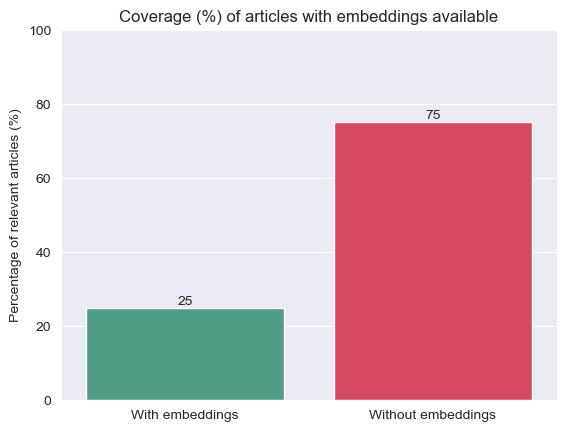

In [39]:
# Check how for how many articles we have the embeddings available
query_articles_embeddings = f"""
SELECT
    COUNT(DISTINCT F.ARTICLE_SID) AS ARTICLE_COUNT
FROM
    {read_schema}.FCT_COLLABORATION F
    INNER JOIN {read_schema}.DIM_ARTICLE A 
    ON F.ARTICLE_SID = A.ARTICLE_SID 
    INNER JOIN {analytics_schema}.TEXT_EMBEDDING_ARTICLE E
    ON E.DOI = A.ARTICLE_DOI
WHERE
    F.IS_EUTOPIAN_PUBLICATION
    AND A.ARTICLE_TITLE <> 'n/a'
"""

df_articles_embeddings = client.query(query_articles_embeddings).to_dataframe()
n_articles_with_embeddings = df_articles_embeddings.iloc[0, 0]

# Visualize the coverage of articles with embeddings available
ax = sns.barplot(x=['With embeddings', 'Without embeddings'],
                 y=[100 * n_articles_with_embeddings / n_relevant_articles,
                    100 * (n_relevant_articles - n_articles_with_embeddings) / n_relevant_articles],
                 hue=['With embeddings', 'Without embeddings'],
                 palette=[palette['good'], palette['bad']])
# Add the data labels to the plot (truncated to 0 decimal points)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge')
plt.ylabel('Percentage of relevant articles (%)')
plt.title('Coverage (%) of articles with embeddings available')
plt.ylim(0, 100)
plt.show()

Given the data coverage, we see several bottlenecks on the data availability. To improve our dataset we will redefine the notion of relevant articles as articles that:
1. Are published by EUTOPIA institutions.
2. Have title available.
3. Have one of the following available: full text, abstract or references.
4. Are written in English.
5. Have the embeddings available. (TODO: this check will be added later as the data is not available yet) 

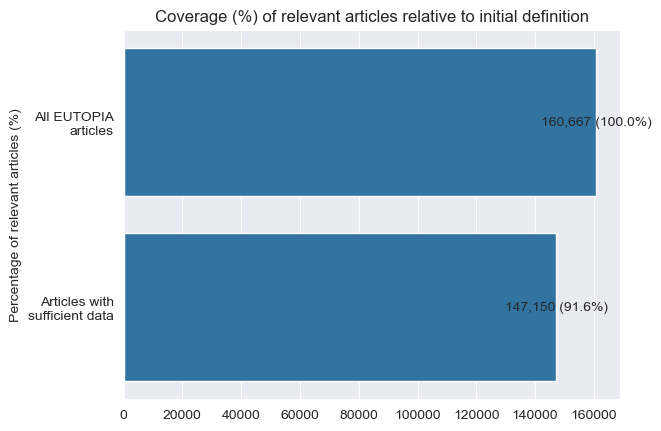

In [40]:
query_articles_relevant = f"""
SELECT
    COUNT(DISTINCT F.ARTICLE_SID) AS ARTICLE_COUNT
FROM
    {read_schema}.FCT_COLLABORATION F
WHERE
    IS_ARTICLE_RELEVANT
"""

df_articles_relevant = client.query(query_articles_relevant).to_dataframe()
n_new_relevant_articles = df_articles_relevant.iloc[0, 0]

# Calculate the percentage of relevant articles
pct_relevant_articles = 100
pct_new_relevant_articles = 100 * n_new_relevant_articles / n_relevant_articles

# Visualize the coverage of relevant articles
ax = sns.barplot(y=['All EUTOPIA\narticles', 'Articles with\nsufficient data'],
                 x=[n_relevant_articles, n_new_relevant_articles])

# Add the data labels to the plot including both the value with thousands comma and the percentage of initial definition
for i, value in enumerate([n_relevant_articles, n_new_relevant_articles]):
    pct = 100 if i == 0 else pct_new_relevant_articles
    label = f'{value:,.0f} ({pct:.1f}%)'
    ax.text(value, i, label, ha='center', va='center')

plt.ylabel('Percentage of relevant articles (%)')
plt.title('Coverage (%) of relevant articles relative to initial definition')
plt.show()

## DIM_AUTHOR
Read the `DIM_AUTHOR` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [41]:
query_author = f"""
SELECT
    *
FROM
    {read_schema}.DIM_AUTHOR
"""

df_author = client.query(query_author).to_dataframe()
df_author.head(10)

,AUTHOR_SID,AUTHOR_FULL_NAME,AUTHOR_ORCID_ID
0,fc4bc41c89df3751a3c41536e97f1ef3,Georg Breidenstein,n/a
1,fe8ae54068d092e6f5dcd0f0ee1a1a6e,Mehmet Fatih Atak,n/a
2,99eaec58af0829b6c376d0d77b7468dc,Roger A Fielding,n/a
3,9fc405d1221beff272e552ca6ace8e59,Zhe Wang,n/a
4,b6ffec3f8937b52e28a958ac7efc44f8,Andreas Debrouwere,n/a
5,c08a49fdf9e5a13f57ceb63a6bf6300b,J Smitz,n/a
6,c758a819852c99f2f5469f2307f898a8,Tim Waterboer,n/a
7,d5571651dcbd2c154e1049b4316a6981,Oskar Frankl,n/a
8,d7698d36cf0a52f463b1c4265c9c08b2,Ling Tian,n/a
9,e75beae7b82e8b5d5ab8422f608218b6,Andrey V. Dobrinyin,n/a


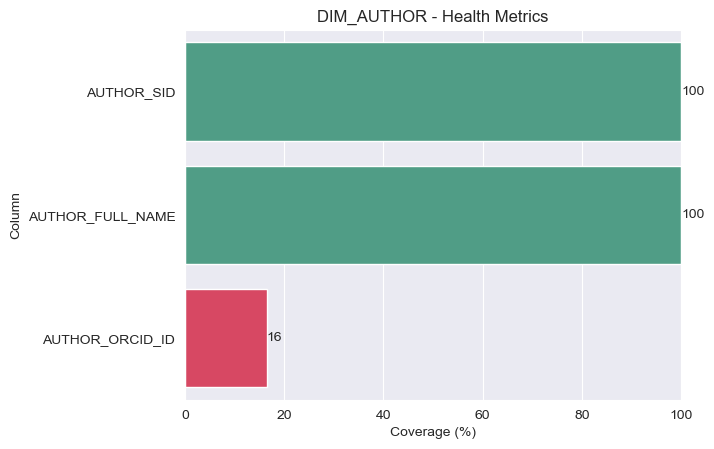

In [42]:
plot_health_metrics(df_source=df_author,
                    table_name='DIM_AUTHOR',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

## FCT_COLLABORATION
Read the `FCT_COLLABORATION` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [43]:
query_collaboration = f"""
SELECT
    *
FROM
    {read_schema}.FCT_COLLABORATION
"""

df_collaboration = client.query(query_collaboration).to_dataframe()
df_collaboration.head(10)

,ARTICLE_SID,AUTHOR_SID,INSTITUTION_SID,ARTICLE_PUBLICATION_DT,IS_SOLE_AUTHOR_PUBLICATION,IS_INTERNAL_COLLABORATION,IS_EXTERNAL_COLLABORATION,IS_EUTOPIAN_COLLABORATION,IS_EUTOPIAN_PUBLICATION,IS_NEW_AUTHOR_COLLABORATION,IS_NEW_INSTITUTION_COLLABORATION,IS_ARTICLE_RELEVANT,PK_COLLABORATION
0,55fcecbf05863ca33465e763806fcf1d,f41d1b0ec7ec4f76fefa2beb57aec978,OTHER,2013-06-22,False,True,False,False,False,True,False,False,0ce70ea5757c045443f8e5666e339485
1,955d782836a113823f98799a798bbc4e,07e7f3bd1c34985432b05319a924006d,n/a,2024-01-01,False,False,True,False,False,False,False,False,dfbff4b0daa3d3f1574c932ea48881ff
2,adad54bfba3efd77bbaef3dd291da46f,f8c25855e11135c40875c7793aa1add0,OTHER,2018-05-27,False,True,False,False,False,True,False,False,f8784f892255986527c5c71012aabc7b
3,8d3a22ceadaca10a96dbe8b896d27b08,e6005e8da82ac3f4a39358ca92f2aebe,n/a,2017-01-01,False,True,False,False,False,False,False,False,f0112e888cd4b97da1e39e0b24edc8a1
4,66cfe8db6bb5e363b208c801225abf15,14f60fbff02dc86f7ba4e75f69758b0d,n/a,2017-01-01,False,True,False,False,False,False,False,False,766c7a3708fff9e79d3ba4368d6a4f0d
5,0d3503aa802f37b4d465196cdbaa1b4f,803310c269dc90e1f8b6783851c270e7,n/a,2023-05-01,False,True,False,False,False,False,False,False,3dee6321e6c44d06774f158042fcacf3
6,0d3503aa802f37b4d465196cdbaa1b4f,e64cd74c6183aae36b865628002f90a5,n/a,2023-05-01,False,True,False,False,False,False,False,False,3d6d6bf30c02e3c2312de50accc06239
7,d3c109706dc7c5b5786c25e789fb0d65,0d0c9cb1aaea692d045e1e01d6ed1572,OTHER,2024-01-24,False,True,False,False,False,True,False,False,b30b89de56b40850a2f70aced7e82f2d
8,fce6de0c6c5902549824adc60a12e9bf,2f0706b2d7d8ddaba2791de390df862e,n/a,2003-10-01,False,True,False,False,False,False,False,False,62e330e0f024ddd55f0d219246c4bb28
9,9bd520d9d41e4b08e6b09f3775ade379,3dfb8470a8264dd85e9965428ee22810,n/a,2022-01-01,False,True,False,False,False,False,False,False,c3ca6f93630022cb6c669b784e5d0874


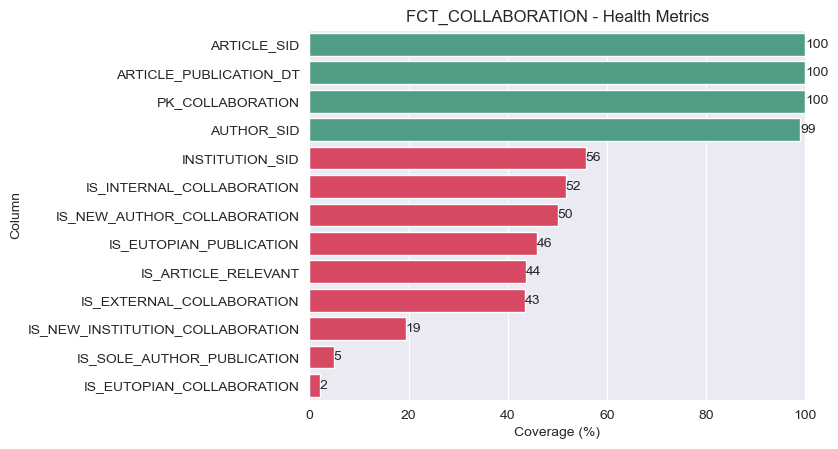

In [44]:
plot_health_metrics(df_source=df_collaboration,
                    table_name='FCT_COLLABORATION',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

## FCT_COLLABORATION_NOVELTY
Read the `FCT_COLLABORATION_NOVELTY` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [45]:
query_collaboration_novelty = f"""
SELECT
    *
FROM
    {read_schema}.FCT_COLLABORATION_NOVELTY
"""

df_collaboration_novelty = client.query(query_collaboration_novelty).to_dataframe()
df_collaboration_novelty.head(10)

,ARTICLE_SID,COLLABORATION_NOVELTY_INDEX,PK_COLLABORATION_NOVELTY
0,e7f7f824a8e3f4d23d2d72b93795830d,2.125,8c7f1c6f57cffc1ae749485fd0eabe55
1,0a207c18f8f4c832315e1b1d7856fceb,2.125,a96d9e32e3297e89e3f8a3167f24066b
2,3e43a2e0015598e5a3e4a796dcfb4c38,2.125,304f310ff0df456de7b8f1d25e51cfe1
3,c5c9b9ea98597a130bb912e7da57a913,2.500,eb0d57436a98430ae6e9db7f02c707b2
4,d657afcc26d6695c3872d470c2b4128e,2.625,47e42efb37b2f20b84e8b757887ea527
5,b781be824274626c3a46ab9c43e52288,2.750,a268dced398d4e68f4d4734c5d4b5788
6,f893755ba512892a4052b7b1c36e5113,3.000,8bbac1e642997d11304c46a888cf9d6f
7,2f44765863c1dbe3e1046bcbfba90b40,3.000,b627ffebd5c77816b33dd0c179e0e3dd
8,2f588a72779cd656ad8a99f5860643d5,3.000,16d15b1db843a5d9de1f79b01eec131e
9,0eb8d212a48a03fb96ef0f4436bb02d4,3.000,f58c94142f04c89150f7dbc66eb4b46f


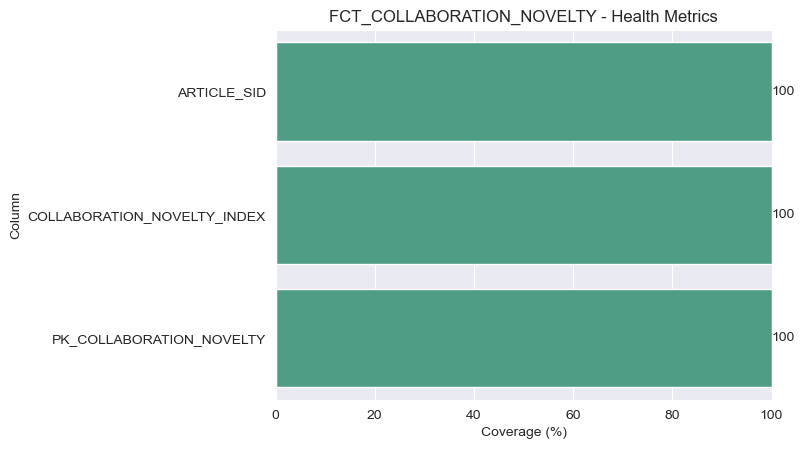

In [46]:
plot_health_metrics(df_source=df_collaboration_novelty,
                    table_name='FCT_COLLABORATION_NOVELTY',
                    default_value=DEFAULT_VALUE,
                    palette=palette)

### Collaboration Novelty Index Distribution
We will check data quality of the `FCT_COLLABORATION_NOVELTY` table by plotting the distribution of the `COLLABORATION_NOVELTY_INDEX` column.

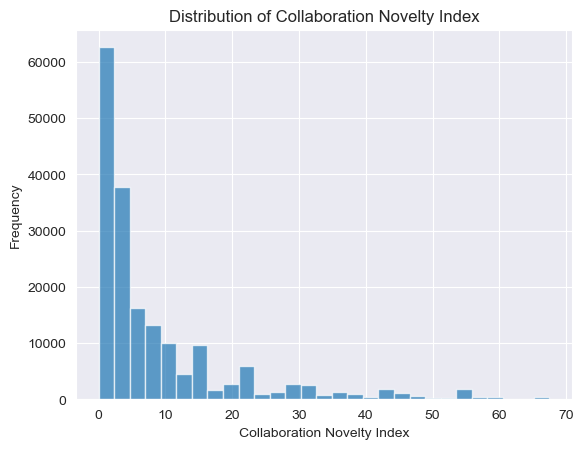

In [47]:
# Cutoff the outliers top 5 percentiles
df_collaboration_novelty_cut = df_collaboration_novelty[
    (df_collaboration_novelty['COLLABORATION_NOVELTY_INDEX'] <
     df_collaboration_novelty['COLLABORATION_NOVELTY_INDEX'].quantile(
         0.95))]

# Define custom bins
custom_bins = np.linspace(df_collaboration_novelty_cut['COLLABORATION_NOVELTY_INDEX'].min(),
                          df_collaboration_novelty_cut['COLLABORATION_NOVELTY_INDEX'].max(), 30)

# Pre-calculate histogram values
counts, bin_edges = np.histogram(df_collaboration_novelty_cut['COLLABORATION_NOVELTY_INDEX'], bins=custom_bins)

# Plot the pre-calculated histogram values
plt.hist(bin_edges[:-1], bins=bin_edges, weights=counts, alpha=0.7, label='Histogram')
plt.xlabel('Collaboration Novelty Index')
plt.ylabel('Frequency')
plt.title('Distribution of Collaboration Novelty Index')
plt.show()

## FCT_ARTICLE_TOPIC
Read the `FCT_COLLABORATION_TYPE` table from the BigQuery dataset and output first few rows of the table to understand what the data looks like.

In [48]:
query_article_topic = f"""
SELECT
    *
FROM
    {read_schema}.FCT_ARTICLE_TOPIC
"""

df_article_topic = client.query(query_article_topic).to_dataframe()
df_article_topic.head(10)

,ARTICLE_SID,RESEARCH_TOPIC_SID,RANK,PK_ARTICLE_TOPIC
0,cef09ce3e821ba425ec7f8f0c9236f04,0cbbb54371c016770e74aa3c528085f6,1,73040a4d12810e5d5663dce02e45f711
1,8e3e40810bdde8cd786891e5d3944f6d,1dedd3ef9e6254029063ddf2eb64bfcc,1,5db6148d03030e1b89de9e50b490eb96
2,25157e00c174f3cae6131d1521915220,1dedd3ef9e6254029063ddf2eb64bfcc,1,0eece02a73a90c83f0f052b5d83cee20
3,069b95f00ee6d66f69d9f4a4579a2d07,d041faf97759c83cb90efe840a9b4ab0,1,491586a8a19e6f7f77c86195bad20c3a
4,24a11c049e43b4c8c527e3a13ebaf3e5,d041faf97759c83cb90efe840a9b4ab0,1,b9611e717d7deb3f2fa6187d2a705e02
5,44e91ed3898c2b173d3cdec95760de0f,d041faf97759c83cb90efe840a9b4ab0,1,f6b4c58894d926787262c826dd1afaed
6,1750aac9bb515ec01c4d8aa5f5968bcd,d041faf97759c83cb90efe840a9b4ab0,1,a885aabc8ff00557e61a39fdbc24663d
7,b062fb84185b298f8da44dc87b929934,d041faf97759c83cb90efe840a9b4ab0,1,cd8e7168e70a39d823f30d5ef5dbbb76
8,d28bd1ffcf08495c283166ba354a68d1,d041faf97759c83cb90efe840a9b4ab0,1,fe5333f87f40f057cab09a8f09935fbc
9,23100d9a855d45dd1013d9d75f5dd05d,d041faf97759c83cb90efe840a9b4ab0,1,2af617273863f2ddb94ff3ff3b90177b


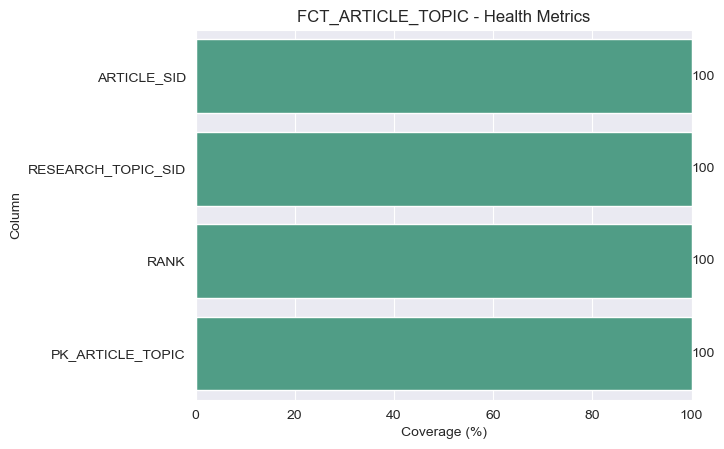

In [49]:
plot_health_metrics(df_source=df_article_topic,
                    table_name='FCT_ARTICLE_TOPIC',
                    default_value=DEFAULT_VALUE,
                    palette=palette)